## Analyzing News Articles With Python (Part 3)

*By Andre Sealy (Updated 06/28/2020)*

This is the third part of a multi-part series in analyzing news articles using Python. Part One involves using Python and the [All Sides](https://www.allsides.com/unbiased-balanced-news) website to extract the most important articles based on the stories that are interesting to us. Part Two involves collecting the most relevant portions of the article, namely the body and the authors, and organizing the articles based on the bias, according to All Sides. In this part, we will be conducting what is known as **sentiment analysis**.

### Sentiment Analysis

Sentiment Analysis is the process of computationally (at least, programming languages)  determining whether a piece of text is positive, negative, or neutral. It's also known as opinion mining, deriving the opinion or attitude of a writer.

We've all received text messages or e-mails, where we are not sure the emotion the sender is trying to convey. Certain words may carry a specific connotation that is not clear to many different types of people. Sentiment Analysis can be considered an unbias way of analyzing text.

Machine Learning practitioners utilize sentiment analysis in several different fields.

* **Politics**: I suppose this project involves politics to some degree, but we can use sentiment analysis to keep track of the consistency between specific statements and actions at the government level.

* **Finance**: As you are already aware, I am in the Finance industry. My personal experience using Sentiment Analysis in Finance consists of analyzing news articles related to specific publicly traded companies and predicting stock movements based on how the news impacted the underlying stock. This is just one example, but there are dozens of different examples of how sentiment analysis is used in Finance.

* **Shopping (Online, Restaurants)**: Have you ever tried to purchase a product on Amazon? (You're human; of course, you have.) How do you know if you can trust the reviews? What about the reviews on a Yelp listing? Sentiment Analysis can help you determine whether or not a review is fake or made by a real person.

In our case, we are using it to examine the bias of news articles. 


#### Importing the Modules

Let's begin to load the necessary modules for the project, which includes the following:

* numpy
* pandas
* matplotlib
* time
* os
* re
* **string**
* **seaborn**
* **nltk**

We've used the majority of the modules in Part One and Two of this tutorial. I'm going to focus primarily on the modules in bold. The `string` module allows us to interact with string objects in python, which is important when conducting sentiment analysis. The module also comes with many different lists of common strings that we may want to eliminate from a body of the text.

The `seaborn` module is similar to the `matplotlib` module, in that it is used for data visualization; however, `seaborn` has a wide variety of visual patterns and themes that can be used for prettifying graphs and charts.

Finally, we will be using the `nltk` module, which stands for **Natural Language Toolkit** Natural Language processing allows humans to interact with computers in ways that allow machines to understand the everyday speech utilized by humans.


In [1]:

#%% import pandas, time to impose rate limits, cloud library
import numpy as np
import time
from google.cloud.language import types
from google.cloud.language import enums
from google.cloud import language
import pandas as pd
import os
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

# Google Application Credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "Your Project API JSON Here"


We're going to be using the `news-corpus-df.csv` file that we created in Part Two. However, we're not going to open the file. We only want certain columns: **date**, **bias**, **text**, **headline**, and **source**. We only want the sources with at least more than 500 characters. Also, we're going to classify the bias of each article: 1 for Left-Learning articles; 3 for Right-Leaning articles, and 2 for the Center.

In [2]:


def read_data(filename):
    # read in csv
    df = pd.read_csv('news-corpus-df.csv')

    # drop text under 500 words
    df = df.drop(df[df.text_len < 500].index)

    # limit df content to bias, text, headline, and source
    df = df.loc[:, ['date', 'bias', 'headline', 'text', 'text_len',  'source']]

    # cleaning the 'bias' column of unnecessary white space
    df['bias'] = df['bias'].apply(lambda x: x.strip()) 

    # convert bias label to number
    df['bias'] = df['bias'].replace({'Left': 1, 'Center': 2, 'Right': 3})

    # classify without center biased news
    # new = new[new.bias != '2']

    return df

# read in file and preview
new = read_data('news-corpus-df.csv')
new.head()



,date,bias,headline,text,text_len,source
0,2020-04-24,2,"b""Inside Trump's proposal to suspend some lega...",WASHINGTON (Reuters) - President Donald Trump ...,5310,Reuters
1,2020-04-24,1,"b""Trump's moves on immigration reveal his true...","Rafia Zakaria is the author of "" The Upstairs ...",8191,CNN - Editorial
2,2020-04-24,3,b'Just imagine if Trump had stopped immigratio...,President Trump announced Monday night that he...,4247,Washington Examiner
3,2020-04-21,1,b'Trump says he will issue order to suspend im...,"Trump, who is running for reelection on his im...",5760,Washington Post
4,2020-04-21,2,b'U.S. coronavirus response deepens divide as ...,ATLANTA (Reuters) - Governors of about half a ...,5319,Reuters


Now that we've structured the data, we can now start using a Natural Language Processing on our dataset.

### Natural Language Processing using Google API

Natural Language Processing (NLP) is a field of Artificial Intelligence that gives the machines the ability to read, understand, and derive meaning from human languages. Python already provides a well-known NLP module for this task, namely the Natural Language Toolkit (NLTK). However, there is a lot that goes into preparing the data to feed through a Naive Bayes or Support Vector Classifier.

![](https://kidquant.com/post/images/Analyzing-News/topics-allsides7.PNG)

As we can see, the process for using the `nltk` module is a painstaking process, as you can see. If we compare it with Google's Natural Language API, the process looks a little more like this:

![](https://kidquant.com/post/images/Analyzing-News/topics-allsides8.PNG)

As we can see, it's much more manageable. No need to look for specific stop words, tokenize the text, or test/train our dataset to fit the module.

To use Google Natural Language API, you need to set up a Cloud Library account, enable the Natural Language API, and download the project file you are using for the API. The tutorial for this process can be found [here](https://cloud.google.com/natural-language/docs/reference/libraries).

The next process involves using Google's NLP API to analyze the articles we've extracted from Part Two. We are going to create a loop that measures the Sentiment and Magnitude of each text and assign it to two new columns.

#### Sentiment and Magnitude

So what is the concept behind **Sentiment** and **Magnitude**, and how does it help us in our analysis?

**Sentiment** attempts to determine the overall attitude (positive or negative) expressed within the text. The of a text will range between -1.0 (negative) and 1.0 (positive). Of course, it goes without saying that a score of 0.0 is considered neutral.

**Magnitude** indicates the overall strength of the emotion (either positive or negative) within the given text. We're not sure how high this metric can go; however, the minimum us always 0. Unlike sentiment, magnitude is not normalized; each expression of emotion within the text (positive and negative) contributes to the text magnitude. So longer text may have greater magnitudes.

In [3]:
client = language.LanguageServiceClient()

# Gather sentiment score and magnitude data for each document
sentiment_list = []
magnitude_list = []

for i in range(0, len(new['text'].values)):
    # specify document type
    document = types.Document(
        content=new['text'].values[i], type=enums.Document.Type.PLAIN_TEXT)

    # detects the sentiment of the text
    sentiment = client.analyze_sentiment(document=document).document_sentiment
    sentiment_list.append(sentiment.score)
    magnitude_list.append(sentiment.magnitude)

    # wait a second to add delay to query
    time.sleep(.100)

# Add sentiment information to data frame
new = new.assign(sentiment=sentiment_list)
new = new.assign(magnitude=magnitude_list)
new.head(11)


,date,bias,headline,text,text_len,source,sentiment,magnitude
0,2020-04-24,2,"b""Inside Trump's proposal to suspend some lega...",WASHINGTON (Reuters) - President Donald Trump ...,5310,Reuters,-0.2,13.100000
1,2020-04-24,1,"b""Trump's moves on immigration reveal his true...","Rafia Zakaria is the author of "" The Upstairs ...",8191,CNN - Editorial,-0.3,23.100000
2,2020-04-24,3,b'Just imagine if Trump had stopped immigratio...,President Trump announced Monday night that he...,4247,Washington Examiner,-0.4,12.500000
3,2020-04-21,1,b'Trump says he will issue order to suspend im...,"Trump, who is running for reelection on his im...",5760,Washington Post,-0.3,14.100000
4,2020-04-21,2,b'U.S. coronavirus response deepens divide as ...,ATLANTA (Reuters) - Governors of about half a ...,5319,Reuters,-0.2,9.800000
5,2020-04-21,3,"b""Trump to 'suspend immigration into the Unite...",Get all the latest news on coronavirus and mor...,5051,Fox News (Online),-0.3,18.200001
6,2020-02-26,3,b'Court hands Trump win in sanctuary city figh...,A federal appeals court on Wednesday handed a ...,4764,Fox News (Online),-0.4,10.600000
7,2020-02-26,2,b'Court rules Trump administration can withhol...,The 2nd U.S. Circuit Court of Appeals ruled We...,1330,Axios,-0.5,3.300000
8,2020-02-14,1,b'Administration to Divert Billions From Penta...,WASHINGTON — The Pentagon plans to divert $3.8...,1585,New York Times (Online News),-0.5,3.400000
9,2020-02-14,3,"b'Trump\xe2\x80\x99s plan to strip planes, shi...",ASKING NEITHER FORGIVENESS NOR PERMISSION: In ...,17786,Washington Examiner,-0.1,36.500000


It's important to note that the Natural Language indicates differences between positive and negative emotion in a document, but does not identify specific positive and negative emotions. For example, "angry" and "sad" are both considered negative emotions. However, when the Natural Language analyzes text that is considered "angry," or text that is considered "sad," the response only indicates that the sentiment in the text is negative, not "sad" or "angry."

For example, our DataFrame has returned the results of our Sentiment Analysis for the articles published from April 14th - 14th. As we can see, the majority of the articles are negative. It unclear whether or not this is any relation to the subject matter or just the nature of the industry, in general ([if it bleeds, it leads](https://www.psychologytoday.com/us/blog/two-takes-depression/201106/if-it-bleeds-it-leads-understanding-fear-based-media)).

The articles with a sentiment score closer to zero are published by **The Associated Press**, **Washington Examiner**, and **Reuters**. Looking at the magnitude scores, we can see the **Washington Examiner** article has a magnitude of 36; however, we have to remember that the value is proportional to the length of the text. Seeing that the article published by the **Washington Examiner** has 17,000+ characters, this makes sense. 

On the other hand, the **Washington Examiner** is not part of the mainstream media and primarily publishes opinion and commentary, which explains the degree in magnitude. If anything, the articles published by the **Washington Examiner**, **Associated Press** and **Reuters** can be considered mixed (a neutral sentiment with a strong degree of emotion)

The articles published by **Axios** and **New York Times** shows a sentiment score of -0.5 and a magnitude of 3.3 and 3.4, respectively, which shows a clear negative sentiment. (Most people would not find this surprising coming from NYT) However, **Fox News (Online)** has two similar stories that convey a slightly less negative sentiment. Because the sentiment is less than -0.5 and the magnitude is relatively strong, we would rate the sentiment for both **Fox News** articles mixed, rather than clearly positive or negative.

"Clearly Positive" or "clearly" negative sentiment varies for different cases and outlets; however, because the vast majority of news articles are negative (or at the very least, has a sentiment score of less than 0), we require a meaningful threshold to determine if an article was truly negative. 

Of course, this is all dependent upon the dataset, as well as the types of articles we extract. However (for now), we choose to use this threshold for news involving political issues.

### Cleaning Up Data For Analaysis

So now that we've done a quick overview of the dataset, we want to organize it in terms of bias. This next code chunk will allow us to do just that.

In [4]:
center = new.loc[new['bias'] ==2]
right = new.loc[new['bias'] == 3]
left = new.loc[new['bias'] ==1]

new = center.append(right, ignore_index=True)
new = new.append(left, ignore_index=True)
new.head()


,date,bias,headline,text,text_len,source,sentiment,magnitude
0,2020-04-24,2,"b""Inside Trump's proposal to suspend some lega...",WASHINGTON (Reuters) - President Donald Trump ...,5310,Reuters,-0.2,13.1
1,2020-04-21,2,b'U.S. coronavirus response deepens divide as ...,ATLANTA (Reuters) - Governors of about half a ...,5319,Reuters,-0.2,9.8
2,2020-02-26,2,b'Court rules Trump administration can withhol...,The 2nd U.S. Circuit Court of Appeals ruled We...,1330,Axios,-0.5,3.3
3,2020-02-14,2,b'Esper defends shifting defense funds for Tru...,U.S. Secretary for Defense Mark Esper speaks d...,3221,Associated Press,-0.2,7.0
4,2020-02-01,2,b'US travel ban: Trump restricts immigration f...,Image copyright Getty Images Image caption The...,3041,BBC News,-0.2,8.3


Now we are going to eliminate all of the unnecessary words, phrases, and propositions that don't contribute to your analysis. We are going to be using this for other forms of analysis later on (such as Topic Model,  Filter Bubles, Echo Chambers, etc).

In [5]:


def text_prepare(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower()
    text = text.replace('\n', ' ')

    letters = list(string.ascii_lowercase)
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    banned = ["’", "’", "“", "—", "”", "‘", "–", '#', '[', '/',
              '(', ')', '{', '}', '\\', '[', ']', '|', '@', ',', ';', '+', '-']
    banned = ''.join(banned) + string.punctuation + ''.join(numbers)
    boilerplate = ['  ', 'https', 'http', 'www', '’s', '―', '/', 'playback', 'get', 'mr', 'mrs', 'ms', 'dr', 'prof', 'news', 'report', 'unsubscribe', 'they', 'must', 'share', 'that', 'view', 'hide', 'copy', 'something', 'enlarge', 'reprint', 'read', '_', 'videos', 'autoplay', 'watched', 'press', '’ve', 'toggle', 'around', 'the', 's.', 'said', 'here©', 'ad', '#', 'andhis', 'click', 'r', 'device',
                   'contributed', 'advertisement', 'the washington', '&', 'follow', 'copyright', 'mrs.', 'photo', 'to', 'also', 'times', 'for', 'however', 'fox', 'this', 'copyright ©', 'ofs', 'just', 'wait', 'n’t', 'told', 'unsupported', 'i', 'caption', 'ms.', '’m', 'paste', '’re', 'replay', 'photos', 'mr.', '©', 'skip', 'watch', '2018', 'cut', 'llc', 'more', 'post', 'embed', 'blog', 'b.', 'associated', 'permission']
    stop_list = set(stopwords.words('english') + boilerplate + letters)

    translation_table = dict.fromkeys(map(ord, banned), ' ')
    text = text.translate(translation_table)
    text = re.sub(' +', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_list])
    return text


# rewrite df with cleaned text
for i in range(0, len(new)):
    new.at[i, 'text'] = text_prepare(new.at[i, 'text'])
    new.at[i, 'headline'] = text_prepare(new.at[i, 'headline'])

new.head()


,date,bias,headline,text,text_len,source,sentiment,magnitude
0,2020-04-24,2,inside trump proposal suspend legal immigratio...,washington reuters president donald trump issu...,5310,Reuters,-0.2,13.1
1,2020-04-21,2,coronavirus response deepens divide trump susp...,atlanta reuters governors half dozen states pu...,5319,Reuters,-0.2,9.8
2,2020-02-26,2,court rules trump administration withhold fund...,nd circuit court appeals ruled wednesday trump...,1330,Axios,-0.5,3.3
3,2020-02-14,2,esper defends shifting defense funds trump xe ...,secretary defense mark esper speaks conference...,3221,Associated Press,-0.2,7.0
4,2020-02-01,2,us travel ban trump restricts immigration nige...,image getty images image us issued immigration...,3041,BBC News,-0.2,8.3


### Visualizations and Statistical Analysis

#### Histogram

Data visualizations allow us to provide a graphical representation of the data. We want to be able to show the relationship between the bias of each article and the level of magnitude for the articles in general. We can demonstrate this with a simple histogram.

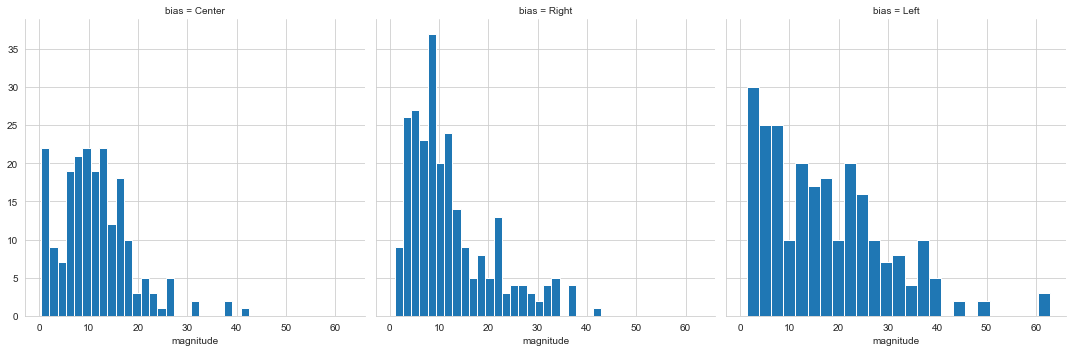

In [6]:
new.to_csv('news-corpus-df-sent.csv', sep='\t', encoding='utf-8')

# convert bias numbers to labels
new['bias'] = new['bias'].replace({1: 'Left', 2: 'Center', 3: 'Right'})
sns.set_style('whitegrid')
# visualize sentiment in relation to bias

g = sns.FacetGrid(data=new, col='bias', col_wrap= 3, size=5 )
g.map(plt.hist, 'magnitude', bins=25)
plt.savefig('histogram.png', bbox_inches='tight')


As we can see from the data, all of the data sets have a right-skew distribution; however, the skew appears to be greater for left-leaning articles. The tails also appear to be fatter. (which means there is a greater distribution of high-emotion articles in the tails) I haven't measured the tails using kurtosis; however, we're not exactly dealing with a normal distribution so it's irrelevant.

A higher degree of emotional content on left-leaning articles is indicative of probably two things:

- Articles from left-leaning sources are needlessly verbose.

- Writers for these outlets tend to interject their emotions into articles they're writing.

#### Box and Whiskers Plot

Although, this information is a little harder to convey on a histogram. It can be seen more clearly on a box and whiskers plot.

The distribution (as well as the skew) are more apparent when presented in the form of a box and whiskers plot. I've also presented the data to show where the outliers are. In order to determine which observations in distribution would be considered an outlier, we need to find something that is called the **Interquartile Range**.

The **interquartile range** or (IQR) measures where the median of the dataset should be. While the range is the measure of the highest and lowest values (visible where the "whiskers" are found), the interquartile range is the range where the bulk of the values lie. It's usually preferred as a measurement of spread when reporting values such as SAT scores.

The IQR can be found by finding the difference between Q3 and Q1:

$$IQR=Q3-Q1$$

![](https://kidquant.com/post/images/Analyzing-News/topics-allsides9.PNG)

Once we have found the IQR for each dataset, we now need to calculate the lower and upper bounds. The lower bounds can be found by taking Q1 and subtracting by 1.5 times the IQR. The upper bound can be found using the same way, except we are using addition instead of subtraction. To bring this explanation in perspective, I'm going to use a few statistics for right-leaning sources.

For example, articles published from right-leaning sources have an average magnitude of ~12.27; the first, second, and third quartile is 6.3, 9.5, and 15, respectively. This means that the IQR is ~8.3 (15 - 6.3). If we take the same 8.7, multiply it by 1.5 and then subtract it from Q1 (6.3-8.3 * 1.5), you'll end up with a lower bound of -5.75. We will never have an observation BELOW this threshold because the lowest magnitude score an article can hold is 0.

The best part about conducting this analysis in python is that we don't need to calculate this ourselves; the `seaborn` module will do it all for us.

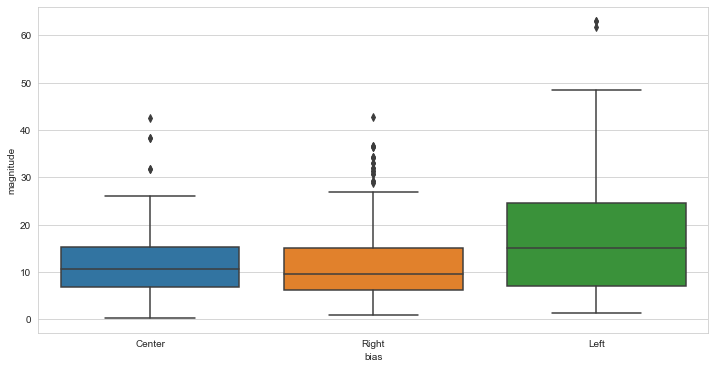

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(x='bias', y='magnitude', data=new)


On the other hand, if we calculate the upper bound (15 + 8.3 * 1.5), we find the upper bound is ~27.5. Each diamond plotted above the whisker is considered an outlier,  and they're lots of them in our right-leaning dataset. However, these articles primarily consist of opinion pieces from the **Washington Times**, **Washington Examiner**, **The Christian Perspective**, **Reason**, and the **National Post**. (The largest magnitude in our dataset for right-leaning sources)

Despite all the outliers, the distribution of the right-leaning dataset is still similar to that of the "politically-neutral" sources. However, there is a major skew in the distribution for left-leaning sources. Although the variation is greater (IQR of 17.6!), the whisker on the far end is much longer than the whisker for right/center-leaning sources.

This data suggests that writers for left-leaning outlets are more likely to implement their personal feelings and emotions into the articles they publish. I suppose we can expect this from outlets such as **Vox** and perhaps **The Guardian**, but the Washington Post and the Los Angeles Times are considered more "news-oriented" outlets.

Perhaps I made a mistake when scraping news and didn't realize I was collecting pieces from the editorial section. OR maybe the mistake was made on their part when mislabeling an article "news" when it should have been labeled "opinion." Who can say?

#### Density Plot

This last plot is known as a density plot, which serves a similar function to the histogram that we used earlier. However, the purpose of a density plot is to visualize the probability distribution of the data by drawing an appropriate continuous curve. Density curves are usually scaled such that the area under the curve equals 1 (provided that the distribution is close to normal).

We have normalized these plots so we can clearly see the distribution for 

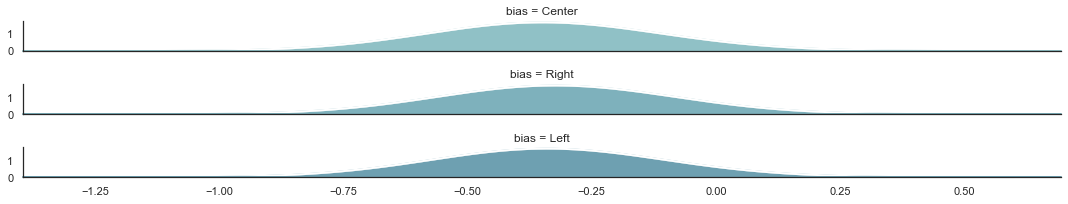

In [8]:
def densityplot(dimension):

    # Initialize the FaceGrid object
    sns.set(style="white", rc={'axes.facecolor': (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(new, row="bias", hue="bias",
                      aspect=15, size=1, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, dimension, clip_on=False,
          shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, dimension, clip_on=False, color='w', lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight='bold', color=color,
                ha='left', va='center', transform=ax.transAxes)

        # Set the subplot to overlap
        g.map(label, dimension)

        # Remove axes details that don't play will with overlap
        g.set_titles('')
        g.set(yticks=[])
        g.despine(bottom=True, left=True)

        return g

sentiment_plot = densityplot('sentiment') 





As we can see from the density plot, there is great chance that a randomly selected news article you read from any source will be negative. The average sentiment of a news article will somewhere between -0.29 and -0.37. It's possible that this is only true for the particular story that I have decided to focus on.